In [1]:
!pip install torchinfo torchmetrics transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.8 MB/s eta 0:00:00


In [2]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchmetrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torchinfo import summary
from tqdm import tqdm
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer

warnings.filterwarnings('ignore')

In [3]:
torch.__version__

'2.2.1+cu121'

In [4]:
!nvidia-smi

Tue Apr 23 15:09:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


def count_param(module: nn.Module, trainable=False) -> int:
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())


def get_lr(optimizer: optim.Optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def freeze_layers(layers: nn.Module) -> None:
    for layer in layers.parameters():
        layer.requires_grad = False


def metrics_to_string(metric_dict: dict) -> str:
    string_list = []
    for key, value in metric_dict.items():
        string_list.append("{}:{:.2f}".format(key, value))
    return " ".join(string_list)

In [6]:
set_seed(2024)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [8]:
class DocumentSentimentDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {"positive": 0, "neutral": 1, "negative": 2}
    INDEX2LABEL = {0: "positive", 1: "neutral", 2: "negative"}
    NUM_LABELS = 3

    def load_dataset(self, path):
        df = pd.read_csv(path)
        df.columns = ["text", "sentiment"]
        df["sentiment"] = df["sentiment"].apply(lambda lab: self.LABEL2INDEX[lab])
        return df

    def __init__(
        self,
        dataset_path: str,
        tokenizer: BertTokenizer,
        no_special_token=False,
        *args,
        **kwargs,
    ):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        data = self.data.loc[index, :]
        text, sentiment = data["text"], data["sentiment"]
        subwords = self.tokenizer.encode(
            text, add_special_tokens=not self.no_special_token
        )
        return np.array(subwords), np.array(sentiment), data["text"]

    def __len__(self):
        return len(self.data)

In [9]:
class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)

        seq_list = []
        for i, (subwords, sentiment, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i, : len(subwords)] = subwords
            mask_batch[i, : len(subwords)] = 1
            sentiment_batch[i, 0] = sentiment

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, sentiment_batch, seq_list

In [10]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p1")
config.num_labels = 3


model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", config=config
).to(device)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# freeze_layers(model.bert.embeddings)
# freeze_layers(model.bert.encoder.layer[:-3])
# freeze_layers(model.bert.encoder)

In [12]:
summary(
    model=model,
    input_size=(1, 7),
    dtypes=[torch.long],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=16,
    row_settings=["var_names"],
)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type (var_name))                                                Input Shape      Output Shape     Param #          Trainable
BertForSequenceClassification (BertForSequenceClassification)          [1, 7]           [1, 3]           --               True
├─BertModel (bert)                                                     [1, 7]           [1, 768]         --               True
│    └─BertEmbeddings (embeddings)                                     --               [1, 7, 768]      --               True
│    │    └─Embedding (word_embeddings)                                [1, 7]           [1, 7, 768]      38,400,000       True
│    │    └─Embedding (token_type_embeddings)                          [1, 7]           [1, 7, 768]      1,536            True
│    │    └─Embedding (position_embeddings)                            [1, 7]           [1, 7, 768]      393,216          True
│    │    └─LayerNorm (LayerNorm)                                      [1, 7, 768]      [1, 7, 768]      1

In [13]:
train_path = "tws-train-ori.csv"
test_path = "tws-test-ori.csv"

In [14]:
train_dataset = DocumentSentimentDataset(train_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_path, tokenizer, lowercase=True)

In [15]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DocumentSentimentDataLoader(
    dataset=train_dataset,
    max_seq_len=512,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_dataloader = DocumentSentimentDataLoader(
    dataset=test_dataset,
    max_seq_len=512,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [16]:
NUM_WORKERS

2

In [17]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
w2i, i2w

({'positive': 0, 'neutral': 1, 'negative': 2},
 {0: 'positive', 1: 'neutral', 2: 'negative'})

In [18]:
# Forward function for sequence classification
def forward_sequence_classification(
    model: BertForSequenceClassification,
    batch_data,
    i2w,
    is_test=False,
    device=device,
    **kwargs,
):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data

    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = (
        torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    )
    label_batch = torch.LongTensor(label_batch)

    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = (
            token_type_batch.cuda() if token_type_batch is not None else None
        )
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(
        subword_batch,
        attention_mask=mask_batch,
        token_type_ids=token_type_batch,
        labels=label_batch,
    )
    loss, logits = outputs[:2]

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])

    return loss, list_hyp, list_label

In [19]:
def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average="macro")
    metrics["REC"] = recall_score(list_label, list_hyp, average="macro")
    metrics["PRE"] = precision_score(list_label, list_hyp, average="macro")
    return metrics

In [20]:
optimizer = optim.Adam(
    model.parameters(),
    lr=3e-6,
    weight_decay=0.3,
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='abs')

In [21]:
epochs = 100

train_loss_values = []
test_loss_values = []
train_metrics_values = []
test_metrics_values = []

for epoch in range(epochs):
    model.train()

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_dataloader, leave=True, total=len(train_dataloader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device="cuda"
        )

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss = total_train_loss + loss.item()

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss / (i+1):.4f} LR:{get_lr(optimizer):.6f}")

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss / (i+1):.4f} {metrics_to_string(metrics)} LR:{get_lr(optimizer):.6f}")
    train_loss_values.append(total_train_loss)
    train_metrics_values.append(metrics['ACC'])

    # Evaluate on validation
    model.eval()

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    test_pbar = tqdm(test_dataloader, leave=True, total=len(test_dataloader))
    with torch.inference_mode():
        for i, batch_data in enumerate(test_pbar):
            batch_seq = batch_data[-1]
            loss, batch_hyp, batch_label = forward_sequence_classification(
                model, batch_data[:-1], i2w=i2w, device="cuda"
            )

            # Calculate total loss
            valid_loss = loss.item()
            total_loss = total_loss + valid_loss

            # Calculate evaluation metrics
            list_hyp += batch_hyp
            list_label += batch_label
            test_pbar.set_description(f"VALID LOSS:{total_loss / (i+1):.4f} {metrics_to_string(metrics)}")

    # Update model
    scheduler.step(total_loss)

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) VALID LOSS:{total_loss / (i+1):.4f} {metrics_to_string(metrics)}")
    test_loss_values.append(total_loss)
    test_metrics_values.append(metrics['ACC'])

(Epoch 1) TRAIN LOSS:1.0414 LR:0.000003: 100%|██████████| 58/58 [00:10<00:00,  5.38it/s]


(Epoch 1) TRAIN LOSS:1.0414 ACC:0.49 F1:0.27 REC:0.35 PRE:0.32 LR:0.000003


VALID LOSS:0.6659 ACC:0.49 F1:0.27 REC:0.35 PRE:0.32: 100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


(Epoch 1) VALID LOSS:0.6659 ACC:0.86 F1:0.31 REC:0.33 PRE:0.29


(Epoch 2) TRAIN LOSS:0.5888 LR:0.000003: 100%|██████████| 58/58 [00:10<00:00,  5.44it/s]


(Epoch 2) TRAIN LOSS:0.5888 ACC:0.86 F1:0.31 REC:0.34 PRE:0.62 LR:0.000003


VALID LOSS:0.5306 ACC:0.86 F1:0.31 REC:0.34 PRE:0.62: 100%|██████████| 15/15 [00:01<00:00, 13.88it/s]


(Epoch 2) VALID LOSS:0.5306 ACC:0.86 F1:0.31 REC:0.33 PRE:0.29


(Epoch 3) TRAIN LOSS:0.5187 LR:0.000003: 100%|██████████| 58/58 [00:10<00:00,  5.55it/s]


(Epoch 3) TRAIN LOSS:0.5187 ACC:0.86 F1:0.31 REC:0.33 PRE:0.29 LR:0.000003


VALID LOSS:0.4840 ACC:0.86 F1:0.31 REC:0.33 PRE:0.29: 100%|██████████| 15/15 [00:00<00:00, 19.95it/s]


(Epoch 3) VALID LOSS:0.4840 ACC:0.86 F1:0.31 REC:0.33 PRE:0.29


(Epoch 4) TRAIN LOSS:0.4791 LR:0.000003: 100%|██████████| 58/58 [00:08<00:00,  6.48it/s]


(Epoch 4) TRAIN LOSS:0.4791 ACC:0.86 F1:0.31 REC:0.34 PRE:0.62 LR:0.000003


VALID LOSS:0.4539 ACC:0.86 F1:0.31 REC:0.34 PRE:0.62: 100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


(Epoch 4) VALID LOSS:0.4539 ACC:0.86 F1:0.31 REC:0.33 PRE:0.29


(Epoch 5) TRAIN LOSS:0.4481 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.42it/s]


(Epoch 5) TRAIN LOSS:0.4481 ACC:0.86 F1:0.31 REC:0.33 PRE:0.29 LR:0.000003


VALID LOSS:0.4345 ACC:0.86 F1:0.31 REC:0.33 PRE:0.29: 100%|██████████| 15/15 [00:00<00:00, 18.72it/s]


(Epoch 5) VALID LOSS:0.4345 ACC:0.86 F1:0.31 REC:0.33 PRE:0.29


(Epoch 6) TRAIN LOSS:0.4311 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.30it/s]


(Epoch 6) TRAIN LOSS:0.4311 ACC:0.86 F1:0.31 REC:0.33 PRE:0.29 LR:0.000003


VALID LOSS:0.4049 ACC:0.86 F1:0.31 REC:0.33 PRE:0.29: 100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


(Epoch 6) VALID LOSS:0.4049 ACC:0.87 F1:0.33 REC:0.35 PRE:0.62


(Epoch 7) TRAIN LOSS:0.4042 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.20it/s]


(Epoch 7) TRAIN LOSS:0.4042 ACC:0.86 F1:0.32 REC:0.34 PRE:0.34 LR:0.000003


VALID LOSS:0.3844 ACC:0.86 F1:0.32 REC:0.34 PRE:0.34: 100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


(Epoch 7) VALID LOSS:0.3844 ACC:0.86 F1:0.33 REC:0.34 PRE:0.40


(Epoch 8) TRAIN LOSS:0.3849 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


(Epoch 8) TRAIN LOSS:0.3849 ACC:0.86 F1:0.36 REC:0.36 PRE:0.38 LR:0.000003


VALID LOSS:0.3654 ACC:0.86 F1:0.36 REC:0.36 PRE:0.38: 100%|██████████| 15/15 [00:00<00:00, 18.00it/s]


(Epoch 8) VALID LOSS:0.3654 ACC:0.87 F1:0.37 REC:0.37 PRE:0.39


(Epoch 9) TRAIN LOSS:0.3724 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.03it/s]


(Epoch 9) TRAIN LOSS:0.3724 ACC:0.86 F1:0.37 REC:0.37 PRE:0.39 LR:0.000003


VALID LOSS:0.3495 ACC:0.86 F1:0.37 REC:0.37 PRE:0.39: 100%|██████████| 15/15 [00:00<00:00, 17.71it/s]


(Epoch 9) VALID LOSS:0.3495 ACC:0.87 F1:0.39 REC:0.39 PRE:0.39


(Epoch 10) TRAIN LOSS:0.3550 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  5.97it/s]


(Epoch 10) TRAIN LOSS:0.3550 ACC:0.87 F1:0.38 REC:0.38 PRE:0.47 LR:0.000003


VALID LOSS:0.3410 ACC:0.87 F1:0.38 REC:0.38 PRE:0.47: 100%|██████████| 15/15 [00:00<00:00, 15.45it/s]


(Epoch 10) VALID LOSS:0.3410 ACC:0.87 F1:0.41 REC:0.43 PRE:0.40


(Epoch 11) TRAIN LOSS:0.3405 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  5.87it/s]


(Epoch 11) TRAIN LOSS:0.3405 ACC:0.87 F1:0.43 REC:0.42 PRE:0.59 LR:0.000003


VALID LOSS:0.3265 ACC:0.87 F1:0.43 REC:0.42 PRE:0.59: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


(Epoch 11) VALID LOSS:0.3265 ACC:0.87 F1:0.43 REC:0.42 PRE:0.73


(Epoch 12) TRAIN LOSS:0.3379 LR:0.000003: 100%|██████████| 58/58 [00:10<00:00,  5.66it/s]


(Epoch 12) TRAIN LOSS:0.3379 ACC:0.87 F1:0.45 REC:0.43 PRE:0.57 LR:0.000003


VALID LOSS:0.3192 ACC:0.87 F1:0.45 REC:0.43 PRE:0.57: 100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


(Epoch 12) VALID LOSS:0.3192 ACC:0.88 F1:0.49 REC:0.46 PRE:0.62


(Epoch 13) TRAIN LOSS:0.3321 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.13it/s]


(Epoch 13) TRAIN LOSS:0.3321 ACC:0.87 F1:0.46 REC:0.44 PRE:0.55 LR:0.000003


VALID LOSS:0.3136 ACC:0.87 F1:0.46 REC:0.44 PRE:0.55: 100%|██████████| 15/15 [00:00<00:00, 18.53it/s]


(Epoch 13) VALID LOSS:0.3136 ACC:0.87 F1:0.47 REC:0.44 PRE:0.53


(Epoch 14) TRAIN LOSS:0.3219 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 14) TRAIN LOSS:0.3219 ACC:0.87 F1:0.47 REC:0.45 PRE:0.54 LR:0.000003


VALID LOSS:0.3079 ACC:0.87 F1:0.47 REC:0.45 PRE:0.54: 100%|██████████| 15/15 [00:00<00:00, 18.41it/s]


(Epoch 14) VALID LOSS:0.3079 ACC:0.88 F1:0.50 REC:0.47 PRE:0.56


(Epoch 15) TRAIN LOSS:0.3195 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.14it/s]


(Epoch 15) TRAIN LOSS:0.3195 ACC:0.88 F1:0.49 REC:0.45 PRE:0.56 LR:0.000003


VALID LOSS:0.3043 ACC:0.88 F1:0.49 REC:0.45 PRE:0.56: 100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


(Epoch 15) VALID LOSS:0.3043 ACC:0.89 F1:0.55 REC:0.52 PRE:0.69


(Epoch 16) TRAIN LOSS:0.3157 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 16) TRAIN LOSS:0.3157 ACC:0.89 F1:0.52 REC:0.49 PRE:0.59 LR:0.000003


VALID LOSS:0.3013 ACC:0.89 F1:0.52 REC:0.49 PRE:0.59: 100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


(Epoch 16) VALID LOSS:0.3013 ACC:0.89 F1:0.54 REC:0.53 PRE:0.72


(Epoch 17) TRAIN LOSS:0.3072 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.15it/s]


(Epoch 17) TRAIN LOSS:0.3072 ACC:0.89 F1:0.51 REC:0.49 PRE:0.56 LR:0.000003


VALID LOSS:0.3007 ACC:0.89 F1:0.51 REC:0.49 PRE:0.56: 100%|██████████| 15/15 [00:00<00:00, 15.74it/s]


(Epoch 17) VALID LOSS:0.3007 ACC:0.89 F1:0.50 REC:0.49 PRE:0.82


(Epoch 18) TRAIN LOSS:0.3052 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.13it/s]


(Epoch 18) TRAIN LOSS:0.3052 ACC:0.89 F1:0.52 REC:0.50 PRE:0.58 LR:0.000003


VALID LOSS:0.2971 ACC:0.89 F1:0.52 REC:0.50 PRE:0.58: 100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


(Epoch 18) VALID LOSS:0.2971 ACC:0.89 F1:0.52 REC:0.52 PRE:0.82


(Epoch 19) TRAIN LOSS:0.3036 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.03it/s]


(Epoch 19) TRAIN LOSS:0.3036 ACC:0.89 F1:0.53 REC:0.50 PRE:0.60 LR:0.000003


VALID LOSS:0.2956 ACC:0.89 F1:0.53 REC:0.50 PRE:0.60: 100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


(Epoch 19) VALID LOSS:0.2956 ACC:0.90 F1:0.53 REC:0.54 PRE:0.82


(Epoch 20) TRAIN LOSS:0.2990 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


(Epoch 20) TRAIN LOSS:0.2990 ACC:0.90 F1:0.53 REC:0.53 PRE:0.59 LR:0.000003


VALID LOSS:0.2935 ACC:0.90 F1:0.53 REC:0.53 PRE:0.59: 100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


(Epoch 20) VALID LOSS:0.2935 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 21) TRAIN LOSS:0.2983 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.04it/s]


(Epoch 21) TRAIN LOSS:0.2983 ACC:0.89 F1:0.51 REC:0.51 PRE:0.54 LR:0.000003


VALID LOSS:0.2915 ACC:0.89 F1:0.51 REC:0.51 PRE:0.54: 100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


(Epoch 21) VALID LOSS:0.2915 ACC:0.89 F1:0.50 REC:0.51 PRE:0.48


(Epoch 22) TRAIN LOSS:0.2922 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 22) TRAIN LOSS:0.2922 ACC:0.90 F1:0.55 REC:0.54 PRE:0.69 LR:0.000003


VALID LOSS:0.2919 ACC:0.90 F1:0.55 REC:0.54 PRE:0.69: 100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


(Epoch 22) VALID LOSS:0.2919 ACC:0.90 F1:0.52 REC:0.55 PRE:0.49


(Epoch 23) TRAIN LOSS:0.2886 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.18it/s]


(Epoch 23) TRAIN LOSS:0.2886 ACC:0.90 F1:0.55 REC:0.54 PRE:0.62 LR:0.000003


VALID LOSS:0.2901 ACC:0.90 F1:0.55 REC:0.54 PRE:0.62: 100%|██████████| 15/15 [00:00<00:00, 16.61it/s]


(Epoch 23) VALID LOSS:0.2901 ACC:0.90 F1:0.51 REC:0.54 PRE:0.49


(Epoch 24) TRAIN LOSS:0.2883 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.24it/s]


(Epoch 24) TRAIN LOSS:0.2883 ACC:0.90 F1:0.54 REC:0.54 PRE:0.63 LR:0.000003


VALID LOSS:0.2886 ACC:0.90 F1:0.54 REC:0.54 PRE:0.63: 100%|██████████| 15/15 [00:00<00:00, 15.13it/s]


(Epoch 24) VALID LOSS:0.2886 ACC:0.90 F1:0.51 REC:0.54 PRE:0.49


(Epoch 25) TRAIN LOSS:0.2882 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


(Epoch 25) TRAIN LOSS:0.2882 ACC:0.90 F1:0.53 REC:0.54 PRE:0.58 LR:0.000003


VALID LOSS:0.2939 ACC:0.90 F1:0.53 REC:0.54 PRE:0.58: 100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


(Epoch 25) VALID LOSS:0.2939 ACC:0.91 F1:0.55 REC:0.60 PRE:0.51


(Epoch 26) TRAIN LOSS:0.2879 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.11it/s]


(Epoch 26) TRAIN LOSS:0.2879 ACC:0.90 F1:0.52 REC:0.53 PRE:0.61 LR:0.000003


VALID LOSS:0.2865 ACC:0.90 F1:0.52 REC:0.53 PRE:0.61: 100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


(Epoch 26) VALID LOSS:0.2865 ACC:0.89 F1:0.50 REC:0.51 PRE:0.48


(Epoch 27) TRAIN LOSS:0.2861 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 27) TRAIN LOSS:0.2861 ACC:0.90 F1:0.54 REC:0.55 PRE:0.62 LR:0.000003


VALID LOSS:0.2863 ACC:0.90 F1:0.54 REC:0.55 PRE:0.62: 100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


(Epoch 27) VALID LOSS:0.2863 ACC:0.89 F1:0.51 REC:0.53 PRE:0.49


(Epoch 28) TRAIN LOSS:0.2779 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.13it/s]


(Epoch 28) TRAIN LOSS:0.2779 ACC:0.90 F1:0.53 REC:0.54 PRE:0.73 LR:0.000003


VALID LOSS:0.2864 ACC:0.90 F1:0.53 REC:0.54 PRE:0.73: 100%|██████████| 15/15 [00:00<00:00, 18.31it/s]


(Epoch 28) VALID LOSS:0.2864 ACC:0.90 F1:0.53 REC:0.56 PRE:0.50


(Epoch 29) TRAIN LOSS:0.2796 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.15it/s]


(Epoch 29) TRAIN LOSS:0.2796 ACC:0.90 F1:0.54 REC:0.54 PRE:0.61 LR:0.000003


VALID LOSS:0.2846 ACC:0.90 F1:0.54 REC:0.54 PRE:0.61: 100%|██████████| 15/15 [00:00<00:00, 17.95it/s]


(Epoch 29) VALID LOSS:0.2846 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 30) TRAIN LOSS:0.2792 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.24it/s]


(Epoch 30) TRAIN LOSS:0.2792 ACC:0.90 F1:0.52 REC:0.53 PRE:0.54 LR:0.000003


VALID LOSS:0.2835 ACC:0.90 F1:0.52 REC:0.53 PRE:0.54: 100%|██████████| 15/15 [00:00<00:00, 15.59it/s]


(Epoch 30) VALID LOSS:0.2835 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 31) TRAIN LOSS:0.2778 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  5.99it/s]


(Epoch 31) TRAIN LOSS:0.2778 ACC:0.90 F1:0.52 REC:0.54 PRE:0.50 LR:0.000003


VALID LOSS:0.2910 ACC:0.90 F1:0.52 REC:0.54 PRE:0.50: 100%|██████████| 15/15 [00:00<00:00, 17.87it/s]


(Epoch 31) VALID LOSS:0.2910 ACC:0.91 F1:0.55 REC:0.60 PRE:0.51


(Epoch 32) TRAIN LOSS:0.2799 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


(Epoch 32) TRAIN LOSS:0.2799 ACC:0.90 F1:0.55 REC:0.56 PRE:0.70 LR:0.000003


VALID LOSS:0.2818 ACC:0.90 F1:0.55 REC:0.56 PRE:0.70: 100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


(Epoch 32) VALID LOSS:0.2818 ACC:0.89 F1:0.51 REC:0.53 PRE:0.49


(Epoch 33) TRAIN LOSS:0.2776 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.15it/s]


(Epoch 33) TRAIN LOSS:0.2776 ACC:0.90 F1:0.53 REC:0.56 PRE:0.62 LR:0.000003


VALID LOSS:0.2819 ACC:0.90 F1:0.53 REC:0.56 PRE:0.62: 100%|██████████| 15/15 [00:00<00:00, 17.83it/s]


(Epoch 33) VALID LOSS:0.2819 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 34) TRAIN LOSS:0.2723 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.21it/s]


(Epoch 34) TRAIN LOSS:0.2723 ACC:0.90 F1:0.53 REC:0.54 PRE:0.60 LR:0.000003


VALID LOSS:0.2821 ACC:0.90 F1:0.53 REC:0.54 PRE:0.60: 100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


(Epoch 34) VALID LOSS:0.2821 ACC:0.89 F1:0.50 REC:0.52 PRE:0.49


(Epoch 35) TRAIN LOSS:0.2714 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


(Epoch 35) TRAIN LOSS:0.2714 ACC:0.90 F1:0.54 REC:0.55 PRE:0.84 LR:0.000003


VALID LOSS:0.2811 ACC:0.90 F1:0.54 REC:0.55 PRE:0.84: 100%|██████████| 15/15 [00:00<00:00, 18.54it/s]


(Epoch 35) VALID LOSS:0.2811 ACC:0.90 F1:0.51 REC:0.54 PRE:0.49


(Epoch 36) TRAIN LOSS:0.2676 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


(Epoch 36) TRAIN LOSS:0.2676 ACC:0.90 F1:0.53 REC:0.55 PRE:0.57 LR:0.000003


VALID LOSS:0.2810 ACC:0.90 F1:0.53 REC:0.55 PRE:0.57: 100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


(Epoch 36) VALID LOSS:0.2810 ACC:0.90 F1:0.54 REC:0.59 PRE:0.51


(Epoch 37) TRAIN LOSS:0.2696 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.14it/s]


(Epoch 37) TRAIN LOSS:0.2696 ACC:0.90 F1:0.54 REC:0.55 PRE:0.64 LR:0.000003


VALID LOSS:0.2816 ACC:0.90 F1:0.54 REC:0.55 PRE:0.64: 100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


(Epoch 37) VALID LOSS:0.2816 ACC:0.90 F1:0.54 REC:0.59 PRE:0.51


(Epoch 38) TRAIN LOSS:0.2709 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.06it/s]


(Epoch 38) TRAIN LOSS:0.2709 ACC:0.91 F1:0.56 REC:0.57 PRE:0.77 LR:0.000003


VALID LOSS:0.2807 ACC:0.91 F1:0.56 REC:0.57 PRE:0.77: 100%|██████████| 15/15 [00:00<00:00, 17.73it/s]


(Epoch 38) VALID LOSS:0.2807 ACC:0.89 F1:0.50 REC:0.51 PRE:0.48


(Epoch 39) TRAIN LOSS:0.2725 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


(Epoch 39) TRAIN LOSS:0.2725 ACC:0.90 F1:0.53 REC:0.56 PRE:0.51 LR:0.000003


VALID LOSS:0.2797 ACC:0.90 F1:0.53 REC:0.56 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


(Epoch 39) VALID LOSS:0.2797 ACC:0.90 F1:0.52 REC:0.55 PRE:0.50


(Epoch 40) TRAIN LOSS:0.2650 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.20it/s]


(Epoch 40) TRAIN LOSS:0.2650 ACC:0.91 F1:0.56 REC:0.56 PRE:0.66 LR:0.000003


VALID LOSS:0.2803 ACC:0.91 F1:0.56 REC:0.56 PRE:0.66: 100%|██████████| 15/15 [00:00<00:00, 18.00it/s]


(Epoch 40) VALID LOSS:0.2803 ACC:0.90 F1:0.53 REC:0.57 PRE:0.50


(Epoch 41) TRAIN LOSS:0.2668 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


(Epoch 41) TRAIN LOSS:0.2668 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85 LR:0.000003


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


(Epoch 41) VALID LOSS:0.2794 ACC:0.89 F1:0.51 REC:0.54 PRE:0.49


(Epoch 42) TRAIN LOSS:0.2682 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


(Epoch 42) TRAIN LOSS:0.2682 ACC:0.90 F1:0.54 REC:0.55 PRE:0.68 LR:0.000003


VALID LOSS:0.2818 ACC:0.90 F1:0.54 REC:0.55 PRE:0.68: 100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


(Epoch 42) VALID LOSS:0.2818 ACC:0.90 F1:0.53 REC:0.58 PRE:0.50


(Epoch 43) TRAIN LOSS:0.2630 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


(Epoch 43) TRAIN LOSS:0.2630 ACC:0.91 F1:0.56 REC:0.57 PRE:0.68 LR:0.000003


VALID LOSS:0.2805 ACC:0.91 F1:0.56 REC:0.57 PRE:0.68: 100%|██████████| 15/15 [00:00<00:00, 15.44it/s]


(Epoch 43) VALID LOSS:0.2805 ACC:0.89 F1:0.50 REC:0.51 PRE:0.49


(Epoch 44) TRAIN LOSS:0.2620 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


(Epoch 44) TRAIN LOSS:0.2620 ACC:0.90 F1:0.53 REC:0.55 PRE:0.84 LR:0.000003


VALID LOSS:0.2790 ACC:0.90 F1:0.53 REC:0.55 PRE:0.84: 100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


(Epoch 44) VALID LOSS:0.2790 ACC:0.90 F1:0.51 REC:0.54 PRE:0.49


(Epoch 45) TRAIN LOSS:0.2657 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


(Epoch 45) TRAIN LOSS:0.2657 ACC:0.90 F1:0.53 REC:0.55 PRE:0.51 LR:0.000003


VALID LOSS:0.2805 ACC:0.90 F1:0.53 REC:0.55 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 17.87it/s]


(Epoch 45) VALID LOSS:0.2805 ACC:0.89 F1:0.50 REC:0.51 PRE:0.48


(Epoch 46) TRAIN LOSS:0.2631 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


(Epoch 46) TRAIN LOSS:0.2631 ACC:0.91 F1:0.54 REC:0.56 PRE:0.52 LR:0.000003


VALID LOSS:0.2789 ACC:0.91 F1:0.54 REC:0.56 PRE:0.52: 100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


(Epoch 46) VALID LOSS:0.2789 ACC:0.90 F1:0.52 REC:0.55 PRE:0.49


(Epoch 47) TRAIN LOSS:0.2667 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 47) TRAIN LOSS:0.2667 ACC:0.90 F1:0.54 REC:0.56 PRE:0.84 LR:0.000003


VALID LOSS:0.2870 ACC:0.90 F1:0.54 REC:0.56 PRE:0.84: 100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


(Epoch 47) VALID LOSS:0.2870 ACC:0.89 F1:0.49 REC:0.49 PRE:0.49


(Epoch 48) TRAIN LOSS:0.2694 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.06it/s]


(Epoch 48) TRAIN LOSS:0.2694 ACC:0.90 F1:0.53 REC:0.55 PRE:0.51 LR:0.000003


VALID LOSS:0.2791 ACC:0.90 F1:0.53 REC:0.55 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


(Epoch 48) VALID LOSS:0.2791 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 49) TRAIN LOSS:0.2643 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.18it/s]


(Epoch 49) TRAIN LOSS:0.2643 ACC:0.91 F1:0.54 REC:0.56 PRE:0.63 LR:0.000003


VALID LOSS:0.2815 ACC:0.91 F1:0.54 REC:0.56 PRE:0.63: 100%|██████████| 15/15 [00:00<00:00, 15.44it/s]


(Epoch 49) VALID LOSS:0.2815 ACC:0.89 F1:0.49 REC:0.50 PRE:0.49


(Epoch 50) TRAIN LOSS:0.2625 LR:0.000003: 100%|██████████| 58/58 [00:09<00:00,  6.04it/s]


(Epoch 50) TRAIN LOSS:0.2625 ACC:0.90 F1:0.53 REC:0.55 PRE:0.67 LR:0.000003


VALID LOSS:0.2791 ACC:0.90 F1:0.53 REC:0.55 PRE:0.67: 100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


(Epoch 50) VALID LOSS:0.2791 ACC:0.89 F1:0.51 REC:0.53 PRE:0.49


(Epoch 51) TRAIN LOSS:0.2612 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.06it/s]


(Epoch 51) TRAIN LOSS:0.2612 ACC:0.91 F1:0.54 REC:0.56 PRE:0.68 LR:0.000000


VALID LOSS:0.2793 ACC:0.91 F1:0.54 REC:0.56 PRE:0.68: 100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


(Epoch 51) VALID LOSS:0.2793 ACC:0.89 F1:0.51 REC:0.53 PRE:0.49


(Epoch 52) TRAIN LOSS:0.2621 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.06it/s]


(Epoch 52) TRAIN LOSS:0.2621 ACC:0.90 F1:0.54 REC:0.56 PRE:0.73 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.54 REC:0.56 PRE:0.73: 100%|██████████| 15/15 [00:00<00:00, 17.90it/s]


(Epoch 52) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 53) TRAIN LOSS:0.2600 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


(Epoch 53) TRAIN LOSS:0.2600 ACC:0.91 F1:0.53 REC:0.55 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.53 REC:0.55 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


(Epoch 53) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 54) TRAIN LOSS:0.2588 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.14it/s]


(Epoch 54) TRAIN LOSS:0.2588 ACC:0.91 F1:0.53 REC:0.55 PRE:0.68 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.53 REC:0.55 PRE:0.68: 100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


(Epoch 54) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 55) TRAIN LOSS:0.2606 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.13it/s]


(Epoch 55) TRAIN LOSS:0.2606 ACC:0.90 F1:0.53 REC:0.55 PRE:0.62 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.53 REC:0.55 PRE:0.62: 100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


(Epoch 55) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 56) TRAIN LOSS:0.2574 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.23it/s]


(Epoch 56) TRAIN LOSS:0.2574 ACC:0.91 F1:0.57 REC:0.58 PRE:0.79 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.57 REC:0.58 PRE:0.79: 100%|██████████| 15/15 [00:00<00:00, 17.00it/s]


(Epoch 56) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 57) TRAIN LOSS:0.2591 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.02it/s]


(Epoch 57) TRAIN LOSS:0.2591 ACC:0.91 F1:0.53 REC:0.56 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.53 REC:0.56 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 18.00it/s]


(Epoch 57) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 58) TRAIN LOSS:0.2639 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.14it/s]


(Epoch 58) TRAIN LOSS:0.2639 ACC:0.91 F1:0.54 REC:0.55 PRE:0.85 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.55 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


(Epoch 58) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 59) TRAIN LOSS:0.2599 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


(Epoch 59) TRAIN LOSS:0.2599 ACC:0.90 F1:0.54 REC:0.55 PRE:0.68 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.54 REC:0.55 PRE:0.68: 100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


(Epoch 59) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 60) TRAIN LOSS:0.2624 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


(Epoch 60) TRAIN LOSS:0.2624 ACC:0.91 F1:0.55 REC:0.57 PRE:0.85 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.55 REC:0.57 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


(Epoch 60) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 61) TRAIN LOSS:0.2590 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.12it/s]


(Epoch 61) TRAIN LOSS:0.2590 ACC:0.91 F1:0.56 REC:0.58 PRE:0.86 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.56 REC:0.58 PRE:0.86: 100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


(Epoch 61) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 62) TRAIN LOSS:0.2599 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 62) TRAIN LOSS:0.2599 ACC:0.90 F1:0.53 REC:0.55 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.53 REC:0.55 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 15.65it/s]


(Epoch 62) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 63) TRAIN LOSS:0.2583 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 63) TRAIN LOSS:0.2583 ACC:0.91 F1:0.54 REC:0.56 PRE:0.52 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.52: 100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


(Epoch 63) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 64) TRAIN LOSS:0.2598 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


(Epoch 64) TRAIN LOSS:0.2598 ACC:0.91 F1:0.55 REC:0.57 PRE:0.68 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.55 REC:0.57 PRE:0.68: 100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


(Epoch 64) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 65) TRAIN LOSS:0.2599 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 65) TRAIN LOSS:0.2599 ACC:0.91 F1:0.53 REC:0.56 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.53 REC:0.56 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


(Epoch 65) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 66) TRAIN LOSS:0.2572 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 66) TRAIN LOSS:0.2572 ACC:0.91 F1:0.53 REC:0.55 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.53 REC:0.55 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


(Epoch 66) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 67) TRAIN LOSS:0.2620 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


(Epoch 67) TRAIN LOSS:0.2620 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


(Epoch 67) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 68) TRAIN LOSS:0.2620 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.13it/s]


(Epoch 68) TRAIN LOSS:0.2620 ACC:0.91 F1:0.54 REC:0.57 PRE:0.52 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.57 PRE:0.52: 100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


(Epoch 68) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 69) TRAIN LOSS:0.2625 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.11it/s]


(Epoch 69) TRAIN LOSS:0.2625 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


(Epoch 69) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 70) TRAIN LOSS:0.2603 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.13it/s]


(Epoch 70) TRAIN LOSS:0.2603 ACC:0.91 F1:0.55 REC:0.56 PRE:0.68 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.55 REC:0.56 PRE:0.68: 100%|██████████| 15/15 [00:00<00:00, 18.32it/s]


(Epoch 70) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 71) TRAIN LOSS:0.2610 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.06it/s]


(Epoch 71) TRAIN LOSS:0.2610 ACC:0.91 F1:0.53 REC:0.56 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.53 REC:0.56 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


(Epoch 71) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 72) TRAIN LOSS:0.2597 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 72) TRAIN LOSS:0.2597 ACC:0.91 F1:0.54 REC:0.56 PRE:0.68 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.68: 100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


(Epoch 72) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 73) TRAIN LOSS:0.2617 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


(Epoch 73) TRAIN LOSS:0.2617 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 18.00it/s]


(Epoch 73) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 74) TRAIN LOSS:0.2603 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 74) TRAIN LOSS:0.2603 ACC:0.91 F1:0.54 REC:0.56 PRE:0.84 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.84: 100%|██████████| 15/15 [00:00<00:00, 17.38it/s]


(Epoch 74) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 75) TRAIN LOSS:0.2610 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


(Epoch 75) TRAIN LOSS:0.2610 ACC:0.91 F1:0.54 REC:0.57 PRE:0.52 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.57 PRE:0.52: 100%|██████████| 15/15 [00:00<00:00, 15.61it/s]


(Epoch 75) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 76) TRAIN LOSS:0.2586 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


(Epoch 76) TRAIN LOSS:0.2586 ACC:0.91 F1:0.53 REC:0.56 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.53 REC:0.56 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 17.95it/s]


(Epoch 76) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 77) TRAIN LOSS:0.2566 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


(Epoch 77) TRAIN LOSS:0.2566 ACC:0.91 F1:0.56 REC:0.57 PRE:0.77 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.56 REC:0.57 PRE:0.77: 100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


(Epoch 77) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 78) TRAIN LOSS:0.2613 LR:0.000000: 100%|██████████| 58/58 [00:10<00:00,  5.36it/s]


(Epoch 78) TRAIN LOSS:0.2613 ACC:0.90 F1:0.53 REC:0.55 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.53 REC:0.55 PRE:0.51: 100%|██████████| 15/15 [00:01<00:00, 13.05it/s]


(Epoch 78) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 79) TRAIN LOSS:0.2629 LR:0.000000: 100%|██████████| 58/58 [00:10<00:00,  5.44it/s]


(Epoch 79) TRAIN LOSS:0.2629 ACC:0.91 F1:0.53 REC:0.56 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.53 REC:0.56 PRE:0.51: 100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


(Epoch 79) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 80) TRAIN LOSS:0.2612 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


(Epoch 80) TRAIN LOSS:0.2612 ACC:0.90 F1:0.52 REC:0.54 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.52 REC:0.54 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 18.37it/s]


(Epoch 80) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 81) TRAIN LOSS:0.2606 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


(Epoch 81) TRAIN LOSS:0.2606 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


(Epoch 81) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 82) TRAIN LOSS:0.2575 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.20it/s]


(Epoch 82) TRAIN LOSS:0.2575 ACC:0.91 F1:0.54 REC:0.57 PRE:0.85 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.57 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 15.86it/s]


(Epoch 82) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 83) TRAIN LOSS:0.2625 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


(Epoch 83) TRAIN LOSS:0.2625 ACC:0.90 F1:0.53 REC:0.55 PRE:0.68 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.53 REC:0.55 PRE:0.68: 100%|██████████| 15/15 [00:00<00:00, 17.92it/s]


(Epoch 83) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 84) TRAIN LOSS:0.2572 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.06it/s]


(Epoch 84) TRAIN LOSS:0.2572 ACC:0.91 F1:0.54 REC:0.56 PRE:0.62 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.62: 100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


(Epoch 84) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 85) TRAIN LOSS:0.2582 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.04it/s]


(Epoch 85) TRAIN LOSS:0.2582 ACC:0.91 F1:0.55 REC:0.57 PRE:0.85 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.55 REC:0.57 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


(Epoch 85) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 86) TRAIN LOSS:0.2620 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.13it/s]


(Epoch 86) TRAIN LOSS:0.2620 ACC:0.91 F1:0.54 REC:0.57 PRE:0.68 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.57 PRE:0.68: 100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


(Epoch 86) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 87) TRAIN LOSS:0.2616 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  5.89it/s]


(Epoch 87) TRAIN LOSS:0.2616 ACC:0.90 F1:0.54 REC:0.55 PRE:0.73 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.54 REC:0.55 PRE:0.73: 100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


(Epoch 87) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 88) TRAIN LOSS:0.2634 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.02it/s]


(Epoch 88) TRAIN LOSS:0.2634 ACC:0.91 F1:0.54 REC:0.57 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.57 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


(Epoch 88) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 89) TRAIN LOSS:0.2587 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


(Epoch 89) TRAIN LOSS:0.2587 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


(Epoch 89) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 90) TRAIN LOSS:0.2593 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


(Epoch 90) TRAIN LOSS:0.2593 ACC:0.90 F1:0.54 REC:0.55 PRE:0.85 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.54 REC:0.55 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


(Epoch 90) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 91) TRAIN LOSS:0.2589 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


(Epoch 91) TRAIN LOSS:0.2589 ACC:0.90 F1:0.53 REC:0.55 PRE:0.67 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.53 REC:0.55 PRE:0.67: 100%|██████████| 15/15 [00:00<00:00, 17.66it/s]


(Epoch 91) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 92) TRAIN LOSS:0.2586 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 92) TRAIN LOSS:0.2586 ACC:0.91 F1:0.54 REC:0.57 PRE:0.52 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.57 PRE:0.52: 100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


(Epoch 92) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 93) TRAIN LOSS:0.2589 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


(Epoch 93) TRAIN LOSS:0.2589 ACC:0.91 F1:0.54 REC:0.56 PRE:0.84 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.84: 100%|██████████| 15/15 [00:00<00:00, 18.37it/s]


(Epoch 93) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 94) TRAIN LOSS:0.2633 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


(Epoch 94) TRAIN LOSS:0.2633 ACC:0.91 F1:0.54 REC:0.56 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 17.91it/s]


(Epoch 94) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 95) TRAIN LOSS:0.2594 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.02it/s]


(Epoch 95) TRAIN LOSS:0.2594 ACC:0.91 F1:0.54 REC:0.55 PRE:0.85 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.55 PRE:0.85: 100%|██████████| 15/15 [00:00<00:00, 17.32it/s]


(Epoch 95) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 96) TRAIN LOSS:0.2578 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.13it/s]


(Epoch 96) TRAIN LOSS:0.2578 ACC:0.91 F1:0.55 REC:0.57 PRE:0.52 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.55 REC:0.57 PRE:0.52: 100%|██████████| 15/15 [00:00<00:00, 15.20it/s]


(Epoch 96) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 97) TRAIN LOSS:0.2589 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


(Epoch 97) TRAIN LOSS:0.2589 ACC:0.91 F1:0.54 REC:0.56 PRE:0.84 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.54 REC:0.56 PRE:0.84: 100%|██████████| 15/15 [00:00<00:00, 17.42it/s]


(Epoch 97) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 98) TRAIN LOSS:0.2619 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


(Epoch 98) TRAIN LOSS:0.2619 ACC:0.90 F1:0.53 REC:0.55 PRE:0.67 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.53 REC:0.55 PRE:0.67: 100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


(Epoch 98) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 99) TRAIN LOSS:0.2614 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.11it/s]


(Epoch 99) TRAIN LOSS:0.2614 ACC:0.91 F1:0.55 REC:0.57 PRE:0.63 LR:0.000000


VALID LOSS:0.2794 ACC:0.91 F1:0.55 REC:0.57 PRE:0.63: 100%|██████████| 15/15 [00:00<00:00, 17.66it/s]


(Epoch 99) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


(Epoch 100) TRAIN LOSS:0.2602 LR:0.000000: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


(Epoch 100) TRAIN LOSS:0.2602 ACC:0.90 F1:0.53 REC:0.55 PRE:0.51 LR:0.000000


VALID LOSS:0.2794 ACC:0.90 F1:0.53 REC:0.55 PRE:0.51: 100%|██████████| 15/15 [00:00<00:00, 17.63it/s]

(Epoch 100) VALID LOSS:0.2794 ACC:0.89 F1:0.50 REC:0.52 PRE:0.48


In [22]:
model.save_pretrained(save_directory="indobert-sentiment-analysis")

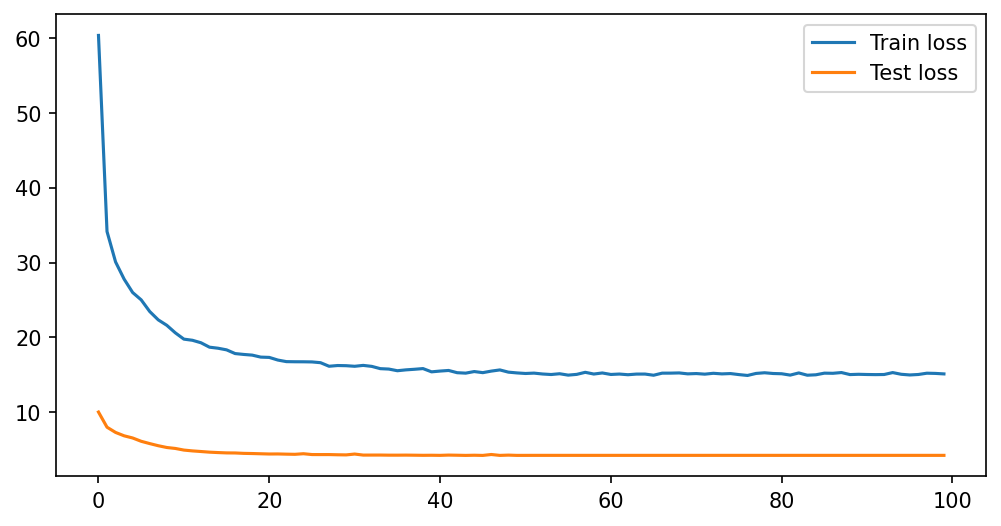

In [23]:
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(range(epochs), train_loss_values, label="Train loss")
plt.plot(range(epochs), test_loss_values, label="Test loss")
plt.legend()

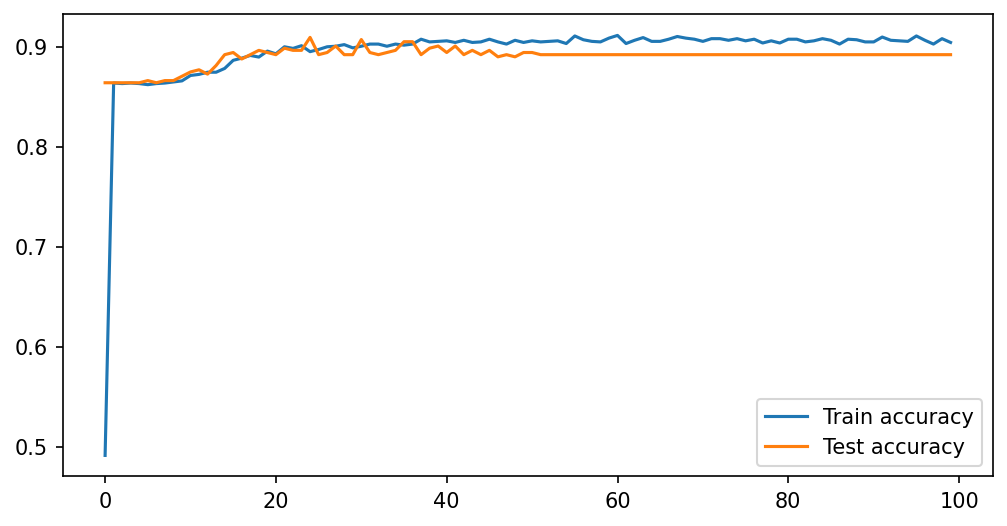

In [24]:
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(range(epochs), train_metrics_values, label="Train accuracy")
plt.plot(range(epochs), test_metrics_values, label="Test accuracy")
plt.legend()

In [25]:
model.eval()
with torch.inference_mode():
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(test_dataloader, leave=True, total=len(test_dataloader))
    for i, batch_data in enumerate(pbar):
        _, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device="cuda"
        )
        list_hyp.extend(batch_hyp)
        list_label.extend(batch_label)

# Save prediction
results_df = pd.DataFrame({"sentiment": list_hyp, "label": list_label}).reset_index(
    drop=True
)
results_df.to_csv("pred.csv", index=False)

100%|██████████| 15/15 [00:00<00:00, 16.89it/s]


In [26]:
cm = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=3)

In [27]:
y_pred = torch.tensor(
    list(
        map(lambda y: 0 if y == 'positive' else 1 if y == 'neutral' else 2 , list_hyp)
    )
)
ground_truth = torch.tensor(
    list(
        map(lambda y: 0 if y == 'positive' else 1 if y == 'neutral' else 2 , list_label)
    )
)

conf_mat = cm(y_pred, ground_truth)

<Axes: >

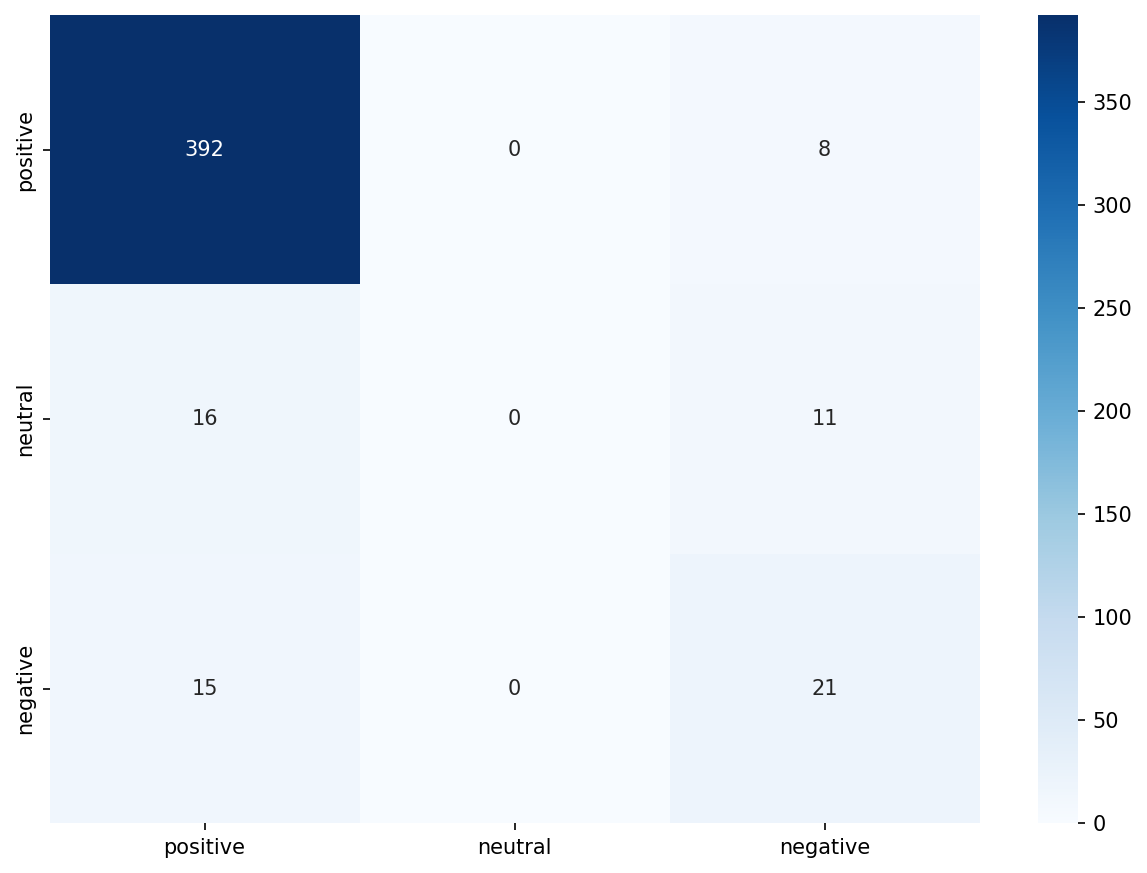

In [28]:
plt.figure(figsize=(10, 7), dpi=150)
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=w2i,
    yticklabels=w2i,
)

In [29]:
document_sentiment_metrics_fn(list_hyp, list_label)

{'ACC': 0.8920086393088553,
 'F1': 0.5017479908763404,
 'REC': 0.5211111111111112,
 'PRE': 0.48390464933018124}